# LSTM Modelling 

In [2]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import warnings
warnings.filterwarnings("ignore")

2023-05-06 19:18:21.784838: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-06 19:18:21.810850: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-06 19:18:21.811799: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 19:18:22.451131: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Refactor

In [3]:
training_data = pd.read_csv("../DateDatasets/training.csv").drop(columns=["Unnamed: 0"])
testing_data = pd.read_csv("../DateDatasets/testing.csv").drop(columns=["Unnamed: 0"])
validating_data = pd.read_csv("../DateDatasets/validation.csv").drop(columns=["Unnamed: 0"])

In [4]:
trips = pd.read_csv("../CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

In [5]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "Workingday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in training_data.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = df

training_data = training_data.join(new_data)

new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "Workingday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in testing_data.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = df

testing_data = testing_data.join(new_data)

new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "Workingday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in validating_data.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = df

validating_data = validating_data.join(new_data)

In [6]:
training_data.to_csv("../DateDatasets/training.csv")
testing_data.to_csv("../DateDatasets/testing.csv")
validating_data.to_csv("../DateDatasets/validation.csv")

## Correlation Features

In [7]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = training_data[[col for col in training_data.columns if "Count" not in col]]
y = training_data['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 12437.41430519349),
 ('ATemp', 11778.44341374909),
 ('Day', 7567.884124144468),
 ('StationEnd', 3579.298897892651),
 ('Hour', 3198.8895282538692),
 ('Humidity', 2562.788968662421),
 ('WeatherSituation', 1261.0759545116875),
 ('Windspeed', 172.82199143829493),
 ('Workingday', 13.614191161218365),
 ('Holiday', 5.09079071574172),
 ('Weekday', 1.8897105928609237),
 ('Year', 0.0)]


## LSTM

In [6]:
epochs = 10
batch_size = 1
verbose = 2

train_errors = [3.22, 3.27, 3.42, 3.41, 3.34, 3.39, 3.73, 3.25, 3.23]
test_errors = [3.88, 3.98, 4.31, 4.30, 4.60, 4.38, 4.33, 3.76, 3.84]

### Method 1
Input: c(t), StationEnd, Temp

Output: c(t+1)

In [12]:
print("""
--------------------------------------------------------------------------------------------

METHOD 1:
Input: c(t), StationEnd, Temp
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp"]

training_data_met1 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met1 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met1.drop(columns=["Count"])
trainY = training_data_met1["Count"]

testX = testing_data_met1.drop(columns=["Count"])
testY = testing_data_met1["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,training_data_met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met1, testing_data_met1]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 1:
Input: c(t), StationEnd, Temp
Output: c(t+1)




2023-05-05 15:08:03.788571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-05 15:08:03.789295: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10


2023-05-05 15:08:04.415352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 15:08:04.417247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 15:08:04.418343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

146965/146965 - 132s - loss: 12.4432 - 132s/epoch - 899us/step
Epoch 2/10
146965/146965 - 127s - loss: 10.9343 - 127s/epoch - 862us/step
Epoch 3/10
146965/146965 - 122s - loss: 10.8084 - 122s/epoch - 829us/step
Epoch 4/10
146965/146965 - 123s - loss: 10.6825 - 123s/epoch - 835us/step
Epoch 5/10
146965/146965 - 122s - loss: 10.6671 - 122s/epoch - 832us/step
Epoch 6/10
146965/146965 - 123s - loss: 10.6258 - 123s/epoch - 834us/step
Epoch 7/10
146965/146965 - 122s - loss: 10.6458 - 122s/epoch - 828us/step
Epoch 8/10
146965/146965 - 122s - loss: 10.6264 - 122s/epoch - 832us/step
Epoch 9/10
146965/146965 - 122s - loss: 10.6614 - 122s/epoch - 830us/step
Epoch 10/10
146965/146965 - 122s - loss: 10.5760 - 122s/epoch - 830us/step
  80/4593 [..............................] - ETA: 2s   

2023-05-05 15:28:40.830759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 15:28:40.832018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 15:28:40.832787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1286/1286 [==============================] - 1s 606us/step
Train Score: 3.22 RMSE
Test Score: 3.88 RMSE


### Method 2
Input: c(t), StationEnd, Temp, ATemp

Output: c(t+1)

In [13]:
print("""
--------------------------------------------------------------------------------------------

METHOD 2:
Input: c(t), StationEnd, Temp, ATemp
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp"]

training_data_met2 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met2 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met2.drop(columns=["Count"])
trainY = training_data_met2["Count"]

testX = testing_data_met2.drop(columns=["Count"])
testY = testing_data_met2["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met2.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met2, testing_data_met2]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 2:
Input: c(t), StationEnd, Temp, ATemp
Output: c(t+1)


Epoch 1/10


2023-05-05 15:30:23.214166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 15:30:23.215322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 15:30:23.215993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

146965/146965 - 122s - loss: 12.6603 - 122s/epoch - 832us/step
Epoch 2/10
146965/146965 - 127s - loss: 11.0075 - 127s/epoch - 865us/step
Epoch 3/10
146965/146965 - 130s - loss: 10.9465 - 130s/epoch - 884us/step
Epoch 4/10
146965/146965 - 128s - loss: 10.8792 - 128s/epoch - 873us/step
Epoch 5/10
146965/146965 - 123s - loss: 10.7360 - 123s/epoch - 838us/step
Epoch 6/10
146965/146965 - 124s - loss: 10.6638 - 124s/epoch - 844us/step
Epoch 7/10
146965/146965 - 122s - loss: 10.6519 - 122s/epoch - 832us/step
Epoch 8/10
146965/146965 - 125s - loss: 10.6291 - 125s/epoch - 853us/step
Epoch 9/10
146965/146965 - 129s - loss: 10.6654 - 129s/epoch - 875us/step
Epoch 10/10
146965/146965 - 125s - loss: 10.6580 - 125s/epoch - 849us/step
 166/4593 [>.............................] - ETA: 2s 

2023-05-05 15:51:19.170510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 15:51:19.171794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 15:51:19.172440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1286/1286 [==============================] - 1s 588us/step
Train Score: 3.27 RMSE
Test Score: 3.98 RMSE


### Method 3
Input: c(t), StationEnd, Temp, ATemp, Day

Output: c(t+1)

In [14]:
print("""
--------------------------------------------------------------------------------------------

METHOD 3:
Input: c(t), StationEnd, Temp, ATemp, Day
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Day"]

training_data_met3 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met3 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met3.drop(columns=["Count"])
trainY = training_data_met3["Count"]

testX = testing_data_met3.drop(columns=["Count"])
testY = testing_data_met3["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,training_data_met3.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met3, testing_data_met3]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 3:
Input: c(t), StationEnd, Temp, ATemp, Day
Output: c(t+1)


Epoch 1/10


2023-05-05 15:51:23.915381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 15:51:23.916438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 15:51:23.917262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

146965/146965 - 126s - loss: 13.9715 - 126s/epoch - 856us/step
Epoch 2/10
146965/146965 - 125s - loss: 11.8684 - 125s/epoch - 849us/step
Epoch 3/10
146965/146965 - 127s - loss: 12.2088 - 127s/epoch - 863us/step
Epoch 4/10
146965/146965 - 128s - loss: 11.7959 - 128s/epoch - 869us/step
Epoch 5/10
146965/146965 - 131s - loss: 12.6428 - 131s/epoch - 889us/step
Epoch 6/10
146965/146965 - 127s - loss: 12.0576 - 127s/epoch - 865us/step
Epoch 7/10
146965/146965 - 124s - loss: 11.8269 - 124s/epoch - 841us/step
Epoch 8/10
146965/146965 - 123s - loss: 11.9822 - 123s/epoch - 839us/step
Epoch 9/10
146965/146965 - 124s - loss: 11.6210 - 124s/epoch - 845us/step
Epoch 10/10
146965/146965 - 124s - loss: 11.5244 - 124s/epoch - 846us/step
 171/4593 [>.............................] - ETA: 2s 

2023-05-05 16:12:22.549327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 16:12:22.550279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 16:12:22.550926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1286/1286 [==============================] - 1s 542us/step
Train Score: 3.42 RMSE
Test Score: 4.31 RMSE


### Method 4
Input: c(t), StationEnd, Temp, ATemp, Day, Hour

Output: c(t+1)

In [15]:
print("""
--------------------------------------------------------------------------------------------

METHOD 4:
Input: c(t), StationEnd, Temp, ATemp, Day, Hour
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Day", "Hour"]

training_data_met4 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met4 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met4.drop(columns=["Count"])
trainY = training_data_met4["Count"]

testX = testing_data_met4.drop(columns=["Count"])
testY = testing_data_met4["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met4.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met4, testing_data_met4]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 4:
Input: c(t), StationEnd, Temp, ATemp, Day, Hour
Output: c(t+1)


Epoch 1/10


2023-05-05 16:12:27.131609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 16:12:27.132533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 16:12:27.133178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

146965/146965 - 122s - loss: 15.2535 - 122s/epoch - 831us/step
Epoch 2/10
146965/146965 - 122s - loss: 12.0927 - 122s/epoch - 827us/step
Epoch 3/10
146965/146965 - 122s - loss: 11.6839 - 122s/epoch - 829us/step
Epoch 4/10
146965/146965 - 121s - loss: 11.6363 - 121s/epoch - 825us/step
Epoch 5/10
146965/146965 - 121s - loss: 11.5699 - 121s/epoch - 824us/step
Epoch 6/10
146965/146965 - 122s - loss: 11.5239 - 122s/epoch - 832us/step
Epoch 7/10
146965/146965 - 121s - loss: 11.6766 - 121s/epoch - 826us/step
Epoch 8/10
146965/146965 - 121s - loss: 11.6648 - 121s/epoch - 823us/step
Epoch 9/10
146965/146965 - 122s - loss: 11.4816 - 122s/epoch - 833us/step
Epoch 10/10
146965/146965 - 121s - loss: 11.5849 - 121s/epoch - 827us/step
 160/4593 [>.............................] - ETA: 2s 

2023-05-05 16:32:43.783449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 16:32:43.784468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 16:32:43.785142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1286/1286 [==============================] - 1s 514us/step
Train Score: 3.41 RMSE
Test Score: 4.30 RMSE


### Method 5
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity

Output: c(t+1)

In [16]:
print("""
--------------------------------------------------------------------------------------------

METHOD 5:
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Humidity", "Hour", "Day"]

training_data_met5 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met5 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met5.drop(columns=["Count"])
trainY = training_data_met5["Count"]

testX = testing_data_met5.drop(columns=["Count"])
testY = testing_data_met5["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met5.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met5, testing_data_met5]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 5:
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity
Output: c(t+1)


Epoch 1/10


2023-05-05 16:39:47.679589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 16:39:47.680647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 16:39:47.681269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

146965/146965 - 126s - loss: 14.5659 - 126s/epoch - 860us/step
Epoch 2/10
146965/146965 - 127s - loss: 11.5752 - 127s/epoch - 861us/step
Epoch 3/10
146965/146965 - 130s - loss: 11.5163 - 130s/epoch - 885us/step
Epoch 4/10
146965/146965 - 131s - loss: 11.4178 - 131s/epoch - 890us/step
Epoch 5/10
146965/146965 - 133s - loss: 11.3800 - 133s/epoch - 907us/step
Epoch 6/10
146965/146965 - 129s - loss: 11.3921 - 129s/epoch - 876us/step
Epoch 7/10
146965/146965 - 132s - loss: 11.3167 - 132s/epoch - 899us/step
Epoch 8/10
146965/146965 - 123s - loss: 11.3515 - 123s/epoch - 836us/step
Epoch 9/10
146965/146965 - 124s - loss: 11.3580 - 124s/epoch - 844us/step
Epoch 10/10
146965/146965 - 126s - loss: 11.4273 - 126s/epoch - 860us/step
 183/4593 [>.............................] - ETA: 2s 

2023-05-05 17:01:09.483676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 17:01:09.484765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 17:01:09.485468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1286/1286 [==============================] - 1s 565us/step
Train Score: 3.34 RMSE
Test Score: 4.60 RMSE


### Method 6
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity, WeatherSituation

Output: c(t+1)

In [17]:
print("""
--------------------------------------------------------------------------------------------

METHOD 6:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Day, WeatherSituation
Output: c(t+1)

""")


cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Humidity", "Hour", "Day", "WeatherSituation"]

training_data_met6 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met6 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met6.drop(columns=["Count"])
trainY = training_data_met6["Count"]

testX = testing_data_met6.drop(columns=["Count"])
testY = testing_data_met6["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,training_data_met6.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met6, testing_data_met6]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 6:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Day, WeatherSituation
Output: c(t+1)


Epoch 1/10


2023-05-05 17:05:17.937597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 17:05:17.938550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 17:05:17.939174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

146965/146965 - 123s - loss: 13.9592 - 123s/epoch - 835us/step
Epoch 2/10
146965/146965 - 121s - loss: 11.7457 - 121s/epoch - 822us/step
Epoch 3/10
146965/146965 - 121s - loss: 11.5996 - 121s/epoch - 825us/step
Epoch 4/10
146965/146965 - 122s - loss: 11.4370 - 122s/epoch - 833us/step
Epoch 5/10
146965/146965 - 124s - loss: 11.2690 - 124s/epoch - 843us/step
Epoch 6/10
146965/146965 - 123s - loss: 11.2282 - 123s/epoch - 838us/step
Epoch 7/10
146965/146965 - 123s - loss: 11.2655 - 123s/epoch - 834us/step
Epoch 8/10
146965/146965 - 122s - loss: 11.8601 - 122s/epoch - 832us/step
Epoch 9/10
146965/146965 - 122s - loss: 11.3790 - 122s/epoch - 828us/step
Epoch 10/10
146965/146965 - 122s - loss: 11.2103 - 122s/epoch - 833us/step
 137/4593 [..............................] - ETA: 3s 

2023-05-05 17:25:41.499113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 17:25:41.500324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 17:25:41.501059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1286/1286 [==============================] - 1s 527us/step
Train Score: 3.39 RMSE
Test Score: 4.38 RMSE


### Method 7
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity, WeatherSituation, Windspeed

Output: c(t+1)

In [8]:
print("""
--------------------------------------------------------------------------------------------

METHOD 7:
Input: c(t), StationEnd, Temp, ATemp, Day, Hour, Humidity, WeatherSituation, Windspeed
Output: c(t+1)

""")


cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Humidity", "Hour", "Day", "WeatherSituation", "Windspeed"]

training_data_met7 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met7 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met7.drop(columns=["Count"])
trainY = training_data_met7["Count"]

testX = testing_data_met7.drop(columns=["Count"])
testY = testing_data_met7["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met7.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met7, testing_data_met7]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 7:
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, Day, WeatherSituation, Windspeed
Output: c(t+1)




2023-05-06 14:01:21.262315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 14:01:21.262919: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-06 14:01:21.412219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gra

Epoch 1/10


2023-05-06 14:01:21.665122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 14:01:21.666447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 14:01:21.667226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

146965/146965 - 122s - loss: 13.8205 - 122s/epoch - 829us/step
Epoch 2/10
146965/146965 - 122s - loss: 11.7929 - 122s/epoch - 827us/step
Epoch 3/10
146965/146965 - 117s - loss: 11.5697 - 117s/epoch - 797us/step
Epoch 4/10
146965/146965 - 120s - loss: 11.8105 - 120s/epoch - 814us/step
Epoch 5/10
146965/146965 - 116s - loss: 11.6799 - 116s/epoch - 793us/step
Epoch 6/10
146965/146965 - 116s - loss: 11.5536 - 116s/epoch - 787us/step
Epoch 7/10
146965/146965 - 116s - loss: 11.4760 - 116s/epoch - 787us/step
Epoch 8/10
146965/146965 - 116s - loss: 11.3920 - 116s/epoch - 792us/step
Epoch 9/10
146965/146965 - 119s - loss: 11.7860 - 119s/epoch - 811us/step
Epoch 10/10
146965/146965 - 119s - loss: 11.5758 - 119s/epoch - 813us/step
  75/4593 [..............................] - ETA: 3s   

2023-05-06 14:21:04.750168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 14:21:04.751428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 14:21:04.752172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1286/1286 [==============================] - 1s 596us/step
Train Score: 3.73 RMSE
Test Score: 4.33 RMSE


### Method 8
Input: c(t), StationEnd, Temp, Hour, Windspeed

Output: c(t+1)

In [11]:
print("""
--------------------------------------------------------------------------------------------

METHOD 8:
Input: c(t), StationEnd, Temp, Hour, Windspeed
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "Hour", "Windspeed"]

training_data_met8 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met8 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met8.drop(columns=["Count"])
trainY = training_data_met8["Count"]

testX = testing_data_met8.drop(columns=["Count"])
testY = testing_data_met8["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met8.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met8, testing_data_met8]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 8:
Input: c(t), StationEnd, Temp, Hour, Windspeed
Output: c(t+1)


Epoch 1/10


2023-05-06 14:23:34.962020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 14:23:34.964040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 14:23:34.965054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

146965/146965 - 125s - loss: 12.2276 - 125s/epoch - 851us/step
Epoch 2/10
146965/146965 - 123s - loss: 10.6923 - 123s/epoch - 839us/step
Epoch 3/10
146965/146965 - 120s - loss: 10.5380 - 120s/epoch - 819us/step
Epoch 4/10
146965/146965 - 120s - loss: 10.4102 - 120s/epoch - 814us/step
Epoch 5/10
146965/146965 - 120s - loss: 10.3153 - 120s/epoch - 817us/step
Epoch 6/10
146965/146965 - 120s - loss: 10.2742 - 120s/epoch - 816us/step
Epoch 7/10
146965/146965 - 120s - loss: 10.2426 - 120s/epoch - 819us/step
Epoch 8/10
146965/146965 - 120s - loss: 10.2100 - 120s/epoch - 815us/step
Epoch 9/10
146965/146965 - 120s - loss: 10.2253 - 120s/epoch - 818us/step
Epoch 10/10
146965/146965 - 120s - loss: 10.2032 - 120s/epoch - 816us/step
 146/4593 [..............................] - ETA: 3s 

2023-05-06 14:43:43.810163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 14:43:43.811710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 14:43:43.812768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1286/1286 [==============================] - 1s 622us/step
Train Score: 3.25 RMSE
Test Score: 3.76 RMSE


### Method 9
Input: c(t), StationEnd, Temp, ATemp, Hour, Windspeed

Output: c(t+1)

In [12]:
print("""
--------------------------------------------------------------------------------------------

METHOD 9:
Input: c(t), StationEnd, Temp, ATemp, Hour, Windspeed
Output: c(t+1)

""")

cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Hour", "Windspeed"]

training_data_met9 = training_data[[col for col in training_data.columns if col in cols]]
testing_data_met9 = testing_data[[col for col in testing_data.columns if col in cols]]

trainX = training_data_met9.drop(columns=["Count"])
trainY = training_data_met9["Count"]

testX = testing_data_met9.drop(columns=["Count"])
testY = testing_data_met9["Count"]

trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,testing_data_met9.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam')
model_met1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.concat([training_data_met9, testing_data_met9]))

# make predictions
trainPredict = model_met1.predict(trainX)
testPredict = model_met1.predict(testX)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

train_errors.append(trainScore)
test_errors.append(testScore)


--------------------------------------------------------------------------------------------

METHOD 9:
Input: c(t), StationEnd, Temp, ATemp, Hour, Windspeed
Output: c(t+1)


Epoch 1/10


2023-05-06 14:43:48.706585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 14:43:48.708238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 14:43:48.709402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

146965/146965 - 121s - loss: 12.4228 - 121s/epoch - 821us/step
Epoch 2/10
146965/146965 - 119s - loss: 10.6690 - 119s/epoch - 809us/step
Epoch 3/10
146965/146965 - 119s - loss: 10.5893 - 119s/epoch - 808us/step
Epoch 4/10
146965/146965 - 118s - loss: 10.5464 - 118s/epoch - 806us/step
Epoch 5/10
146965/146965 - 118s - loss: 10.5098 - 118s/epoch - 805us/step
Epoch 6/10
146965/146965 - 117s - loss: 10.3983 - 117s/epoch - 799us/step
Epoch 7/10
146965/146965 - 118s - loss: 10.3679 - 118s/epoch - 803us/step
Epoch 8/10
146965/146965 - 125s - loss: 10.3627 - 125s/epoch - 848us/step
Epoch 9/10
146965/146965 - 129s - loss: 10.3457 - 129s/epoch - 875us/step
Epoch 10/10
146965/146965 - 118s - loss: 10.3265 - 118s/epoch - 802us/step
 159/4593 [>.............................] - ETA: 2s 

2023-05-06 15:03:50.545774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 15:03:50.546977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 15:03:50.547782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1286/1286 [==============================] - 1s 632us/step
Train Score: 3.23 RMSE
Test Score: 3.84 RMSE


## Graphs

Text(0.5, 0, 'Methods')

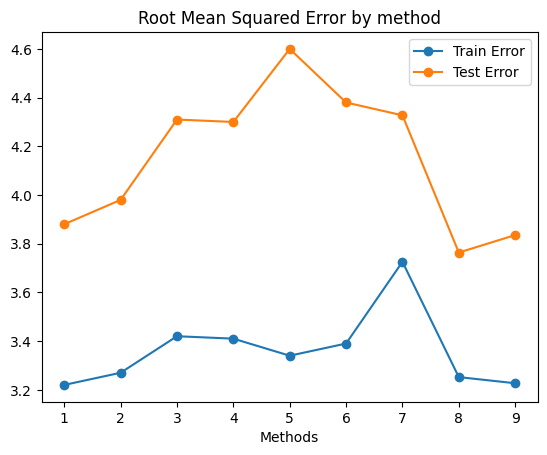

In [13]:
plt.plot(list(range(1,len(train_errors)+1)), train_errors, marker="o")
plt.plot(list(range(1,len(test_errors)+1)), test_errors, marker="o")
plt.legend(["Train Error", "Test Error"])
plt.title("Root Mean Squared Error by method")
plt.xlabel("Methods")